### Ceci est le fichier principal, pour l'instant il regroupe toutes les fonctions et le main

In [1]:
#import
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import win32gui
import time
from pynput.mouse import Controller, Button
import random
import socket
import sys, os
import matplotlib.pyplot as plt
from tensorflow import keras
import PIL
from PIL import Image
from PIL import ImageDraw
from PIL import ImageGrab
sys.path.append('..')
from utilitaire.imgAiTrainer.imgAiTrainer import Trainer
import win32gui as wingui
import re

tr = Trainer()
Max=5
limite=8
recupScore=False

### Fonctions pour cliquer

In [2]:
#fonction de vérification de position de la souris x,y -> Position du curseur / xF_g,yF_g -> position en haut à gauche de la fenêtre / xF_d,yF_d -> position en bas à droite de la fenêtre
def isSortie(x,y):
    #Si le curseur est sorti de la fenêtre je return False sinon je return True
    return x < 0 or x > 800 or y < 0 or y > 600

#fonction qui traduit les coordonnée relative à la fenêtre en coordonnée relative à l'écran
def viser(xF_g,yF_d,xV,yV):
        mouse.position=(xV+xF_g+2,yV+yF_d)

#fonction de clique
def cliquer():
    mouse.press(Button.left)
    mouse.release(Button.left)

### Fonctions pour récupérer l'image du jeu

In [3]:
#### Fonctions pour récupérer l'image du jeu
#retourne la position de la fenêtre d'Osu
def position():
    def callback(handle, data):
        if(re.match(r".*osu.*", wingui.GetWindowText(handle))):
            pos = (wingui.GetWindowRect(handle))
            tabPos.append(pos)

    tabPos = []
    wingui.EnumWindows(callback, None)
    return tabPos

#retourne l'image sous forme de matrice
def Foncimg(x,y,x1,y1):
    img = ImageGrab.grab(bbox=(x+3,y+26,x1-3,y1-3))
    img = img.resize((160, 120))
    img = keras.preprocessing.image.img_to_array(img)
    imgIa = np.expand_dims(img, axis=0)
    return imgIa

### Fonctions pour récupérer le score

In [4]:
def getScore(p):
    TCP_IP = '127.0.0.1'
    TCP_PORT = p
    MESSAGE = b'getScore'

    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.connect((TCP_IP, TCP_PORT))
    s.send(MESSAGE)
    ret = s.recv(1024).decode('utf-8')
    if(ret != ''):
        ret=int(ret)
    s.close()
    return ret
    

### Fonctions pour l'IA supervisée

In [5]:
#Fonction pour l'IA supervisée
def show_sample(img):
    figure, axis = plt.subplots(1,1)
    axis.imshow(img)
    
def show_sample2(img,img2):
    figure, (axis1, axis2) = plt.subplots(1,2)
    axis1.imshow(img)
    axis2.imshow(img2)

#On charge les poids et le modèle entrainé
model = keras.models.load_model('save/model/model')
model.load_weights('save/poids/model')



### Fonctions pour l'IA par renforcement

In [6]:
#Creation du model pour clic
#batchshape: ensemble; ici: ensemble de taille indéerminé avec chacune 3 valeur (x,y,difference entre rayon)
Input = tf.keras.Input([None, 1])

layer = tf.keras.layers.Dense(8, 'relu',True).apply(Input)
#1 neurone de sortis: clic:oui ou non
#linéaire car on aura un espérence du nombre de récompense.
output = tf.keras.layers.Dense(1, 'linear',True).apply(layer)
modelClic = tf.keras.Model(Input, output)
model_optimizer = tf.keras.optimizers.Adam(0.01)

        
def model_loss(tf_states, tf_actions, Qtargets):
                return modelClic.predict(tf_states).sub(Qtargets).square().mul(tf_actions).mean()


#Choix si greed ou explore.
def pickActionClic(st, eps):
    st_tensor = tf.constant(st[2])
    if (random.uniform(0,1) < eps): # Pick a random action
            act = [random.randint(0,1)]
    else:
        result = modelClic.predict(st_tensor) #predis les possibilitées
        argmax = result.argMax(1) #récup le chemin avec le meilleur résultat.
        act = argmax.buffer().values[0]
        argmax.dispose()
        result.dispose()
    #st_tensor.dispose()
    return act

Instructions for updating:
Please use `layer.__call__` method instead.


In [7]:
def pickAction(st,eps):
    act=[0]
    #act=pickActionClic(st,eps)
    if(st[2]<limite):
        act[0]=1
    else:
        act[0]=0 
    act+=[st[0],st[1]] #ajout de x et y; à modifier
    return act

def doAction(act):
    score=''
    if(act[0]==1):
        viser(posFenetre[0],posFenetre[1],act[1],act[2])
        cliquer();
    if(recupScore):
        score=getScore(12345)
    return score

def train_model(states,actions,rewards,model):
    size=len(states)
    
    #Transformer les listes en tensor
    tf_states = tf.convert_to_tensor(states)
    tf_rewards = tf.convert_to_tensor(rewards)
    tf_actions = tf.convert_to_tensor(actions)
    
    #Entrainement
    batch_size=32
    b=0
    while b<batch_size:
        if b + batch_size < size:
            to=batch_size
        else:
            to=size+b
        tf_states_b = tf_states[b: to]
        tf_actions_b = tf_actions[b: to]
        tf_rewards_b = tf_rewards[b: to]
        
        #model_optimizer.minimize(model_loss(tf_states_b, tf_actions_b, tf_rewards_b))
        
        #Liberation mémoire
        del tf_states_b
        del tf_actions_b
        del tf_rewards_b
        
        b+=32
    
    #Liberation mémoire
#     tf_states.dispose()
#     tf_actions.dispose()
#     tf_rewards.dispose()

### Fonction pour obtenir la position du cercle


In [8]:
def recupPositionCercle():
    #On récupère l'image
    img=Foncimg(posFenetre[0],posFenetre[1],posFenetre[2],posFenetre[3])
    #On obtient les prédiction de l'IA supervisée en un tableau
    y_pred = model.predict(img)
    
    #On return les données à la forme désirée
    return [y_pred[0][0],y_pred[0][1],y_pred[0][3]-y_pred[0][2]]


<function matplotlib.pyplot.show(*args, **kw)>

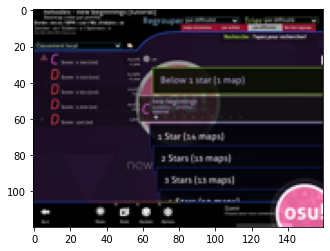

In [9]:
import time
time.sleep(5)
posFenetre=position()
img=Foncimg(posFenetre[0][0],posFenetre[0][1],posFenetre[0][2],posFenetre[0][3])
plt.imshow(img[0]/255)
plt.show

In [10]:
# # -*- coding: utf-8 -*-
# from configOsu import Config
# import win32gui
# import time


# cf = Config()

# cf.config()
# results = []

# while(1):
#     time.sleep(1)
#     window_handle = win32gui.FindWindow(None, "osu!")
#     if window_handle!=0 and win32gui.GetClassName(window_handle)[0:28] == "WindowsForms10.Window.2b.app":
#         print("jeu Osu! lancé")
#         break
    
# window_handle = win32gui.FindWindow(None, "osu!")
# while window_handle!=0 and win32gui.GetClassName(window_handle)[0:28]=="WindowsForms10.Window.2b.app":
#     time.sleep(1)
#     window_handle = win32gui.FindWindow(None, "osu!")

    
# time.sleep(1)

# print("jeu Osu! fermé")
# cf.reload()

## main:

In [11]:
#AlgoFinal

eps=1 # exploration
reward=0

mouse= Controller()

#On récupère la position de la fenêtre d'osu, on considère qu'elle ne bougera pas,et que le jeu est en 800*600 fenêtré
posFenetre=position()
posFenetre=posFenetre[0]
#Stockage experience
actions=[[0,0,0] for i in range(Max)]
rewards=[[0] for i in range(Max)]
states=[[0,0,0] for i in range(Max)]

st=recupPositionCercle()
flucher=getScore(12345)
while(st[2]<0):
    st=recupPositionCercle()
i=0       
while i<Max:
    action=pickAction(st,eps)#appel IA
    reward=doAction(action)#Fait l'action et récupère le nombre de points reçus
    if(reward !=''):
        print(st[2])
        print(reward)
        i+=1
    
    
        
#     states[i]=st
#     actions[i]=action
#     rewards[i]=[reward]
    
#     train_model(states,actions,rewards,model)
    st=recupPositionCercle()
    while(st[2]<0):
        st=recupPositionCercle()
    


4.284607
300
4.404804
300
0.16296005
300
3.6272888
300
1.9482841
300
4.92231
300
0.5895157
300
2.1936264
300
1.640934
300
2.5739975
300
